In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR

# Import the functions from our new library
from analysis_lib.data_loader import load_and_prepare_data
from analysis_lib.forecasting_models import train_var_model, generate_forecast
from analysis_lib.plotting import plot_correlation_heatmap, plot_forecast

# Configure plotting style
sns.set(style="whitegrid")

1. Introduction: Understanding Alcohol Consumption Trends in Russia

This analysis explores the dynamics of alcohol consumption in Russia from 1998 to 2023. The dataset includes yearly per capita consumption of wine, beer, vodka, and brandy. Our goal is to understand the relationships between these beverages and to build a forecasting model to predict future consumption trends. This can provide insights into public health, economic factors, and cultural shifts over time.

In [ ]:
df = load_and_prepare_data()
print("Data loaded and prepared successfully. Displaying first 5 rows:")
df.head()

Data loaded and prepared successfully. Displaying first 5 rows:


/home/raimundoivy/russian_alcohol_consumption_analysis/analysis_lib/data_loader.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[col] = pd.to_numeric(final_df[col], errors='coerce')
/home/raimundoivy/russian_alcohol_consumption_analysis/analysis_lib/data_loader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.dropna(inplace=True)


,wine,beer,vodka,brandy
Year,,,,
1998-01-01,3.5,27.6,14.7,0.3
1999-01-01,3.4,30.6,15.2,0.2
2000-01-01,3.6,35.8,14.6,0.3
2001-01-01,3.9,43.5,14.3,0.3
2002-01-01,4.3,48.7,14.5,0.4


2. Exploratory Data Analysis: Visualizing the Relationships

Before modeling, it's crucial to understand the data. A correlation matrix gives us a first look at how the consumption of different beverages might be related. A positive correlation suggests that as consumption of one beverage goes up, the other tends to go up as well. A negative correlation suggests an inverse relationship.

Generating correlation heatmap...


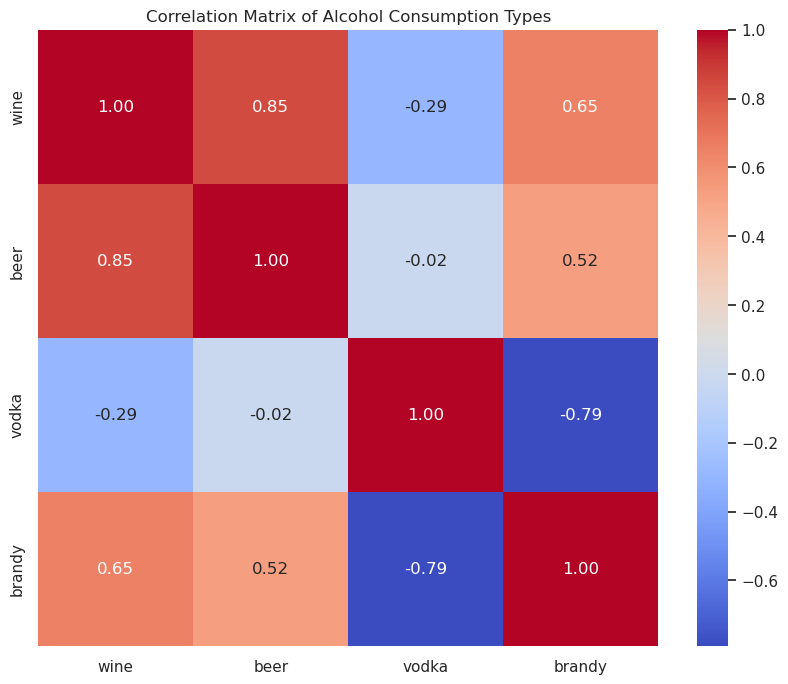

In [ ]:
print("Generating correlation heatmap...")
fig_heatmap = plot_correlation_heatmap(df)
plt.show()

Interpretation: The heatmap reveals some interesting relationships. For instance, we can observe the correlation values between vodka and beer, or wine and brandy. This initial analysis helps justify the use of a Vector Autoregression (VAR) model, which is designed to capture the interdependencies among multiple time series.

3. Time-Series Forecasting with a VAR Model

We will use a Vector Autoregression (VAR) model to forecast future consumption. The VAR model is powerful because it models each variable as a function of its own past values and the past values of all other variables in the system. After testing for the optimal lag order (as shown in the original analysis), a lag of 1 was chosen for the final model.

In [4]:
# The model training logic is now a single, reusable function.
print("Training the VAR model...")
fitted_model = train_var_model(df)
print(fitted_model.summary())

Training the VAR model...
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 16, Sep, 2025
Time:                     21:14:29
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -5.42897
Nobs:                     25.0000    HQIC:                  -6.13362
Log likelihood:          -41.8430    FPE:                 0.00169138
AIC:                     -6.40407    Det(Omega_mle):     0.000815675
--------------------------------------------------------------------
Results for equation wine
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             2.345180         0.593459            3.952           0.000
L1.wine           0.820321         0.124343            6.597           0.000
L1.beer           0.044715         0.010411        

/home/raimundoivy/anaconda3/envs/russian_alcohol_analysis/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [5]:
print("Generating 5-year forecast...")
forecast_df = generate_forecast(fitted_model, steps=5)
print("Forecasted Values (Liters per capita):")
print(forecast_df)

Generating 5-year forecast...
Forecasted Values (Liters per capita):
                wine       beer     vodka    brandy
2024-12-31  3.729476  50.303033  5.458161  0.875633
2025-12-31  3.493071  48.181142  4.834294  0.874829
2026-12-31  3.288175  46.113215  4.235143  0.881531
2027-12-31  3.078732  44.000775  3.662172  0.889827
2028-12-31  2.853891  41.826539  3.114660  0.897682


/home/raimundoivy/russian_alcohol_consumption_analysis/analysis_lib/forecasting_models.py:41: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(years=1),


Plotting the historical data against the forecast...


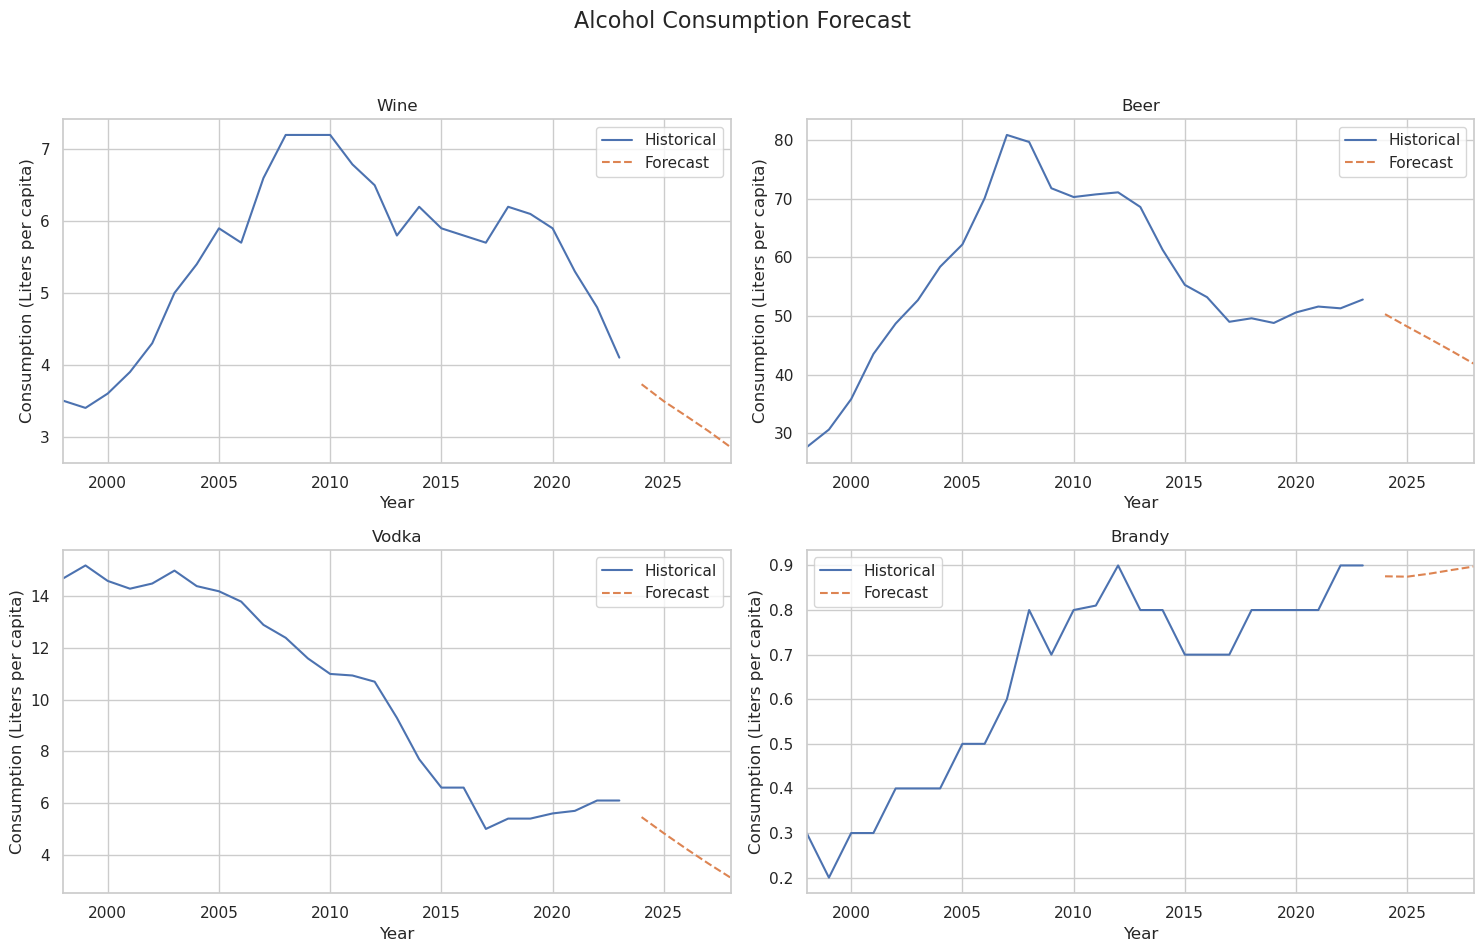

In [6]:
print("Plotting the historical data against the forecast...")
fig_forecast = plot_forecast(df, forecast_df)
plt.show()

5. Conclusion

The forecast plot provides a clear visual of the expected trends for wine, beer, vodka, and brandy consumption. This modularized approach ensures that our analysis is not only accurate but also reproducible and easy to maintain. The separation of concerns between data loading, modeling, and plotting allows for cleaner code and a more professional workflow.